Загружаем необходимые библиотеки

In [1]:
#импортируем библиотеку для проверки файлов в указанных дирректориях
import os

#импортируем библиотеки для работы с данными
import pandas as pd
import numpy as np

#импортируем библиотеки для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns

#импортируем библиотеку для чтения изображений
from PIL import Image

#импортируем модель и слои для построения сверточной нейронной сети
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

#импортируем динамический загрузчик данных
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Исследовательский анализ данных

### Проверка размера выборки

Перым делом проверим, что находится в указанной директории

In [2]:
# Получаем список файлов и папок по указанному пути
files = os.listdir('/datasets/faces/')
print(files)

['labels.csv', 'final_files']


Как видим, там находится папка с изображениями и таблица с размеченным целевым признаком и наименованиями изображений. Посмотрим кол-во изображений в папке для обучения и выведем наименования первых 10

In [3]:
# Получаем список изображений
photos = os.listdir('/datasets/faces/final_files')
print(f'Кол-во фотографий для обучения: {len(photos)}' )
print(f'Наименования первых 10 фотографий для обучения: {photos[:10]}')

Кол-во фотографий для обучения: 7591
Наименования первых 10 фотографий для обучения: ['005226.jpg', '007426.jpg', '001184.jpg', '007520.jpg', '004415.jpg', '001798.jpg', '002797.jpg', '004223.jpg', '003420.jpg', '003067.jpg']


В файловой системе файлы не отсортированы в алфавитном порядке, поэтому применим сортировку и глянем на первые 10 файлов снова

In [4]:
print(sorted(photos)[:10])

['000000.jpg', '000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg']


Теперь взглянем на таблицу и посмотрим ее содержимое

In [5]:
df = pd.read_csv('/datasets/faces/labels.csv')
display(df.head(10))
df.info()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В загруженном датасете:
- 7591 строка, что соответствует кол-ву фотографий в папке `/datasets/faces/final_files`. Наименования первых 10 фотографий в датасете также соответствуют названиям первых 10 файлов с фотографиями
- нет явных пропущенных значений
- наименования столбцов приведены к `змеиному` регистру
- типы данных в столбцах корректны 

### Распределение целевого признака

Построим график распределения целевого признака размеченного датасета вместе с диаграммой размаха

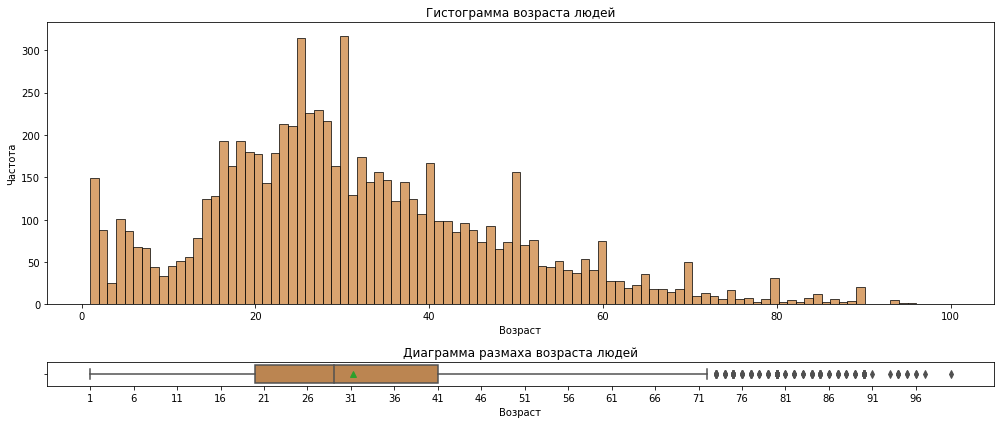

In [24]:
#добавили параметр gridspec_kw для того, чтобы изменить высоту графика сверху и снизу
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14,6), gridspec_kw={'height_ratios': [12, 1]})
sns.histplot(data = df, x ='real_age', color = 'peru', bins = 100, legend = False, ax=axes[0])
axes[0].set_title('Гистограмма возраста людей')
axes[0].set_xlabel('Возраст')
axes[0].set_ylabel('Частота')

sns.boxplot(data = df, x ='real_age', color='peru',ax=axes[1], showmeans = True)        
#добавляем больше делений на оси x от min() до max() значений с шагом 5
axes[1].set_xticks(np.arange(df['real_age'].min(), df['real_age'].max(), 5))
axes[1].set_title('Диаграмма размаха возраста людей')
axes[1].set_xlabel('Возраст')
axes[1].set_ylabel('')

#настраиваем динамическое отображения графиков
plt.tight_layout()
plt.show()

**Из графиков видно:**
 - чаще всех встречаются люди в возрасте от 26 до 32 лет
 - люди в возрасте от 20 до 41 года составляют 50% людей, входящих в диапазон с самыми распространенными значениями вокруг медианы (межквартильный размах)
 - медианное значение возраста составляет 29 лет
 - не мало добавлено фотографий младенцев до 3 лет
 - пенсионеров свыше 70 лет намного меньше, чем остальных возрастных групп

### Отображение части фотографий

Воспользуемся библиотекой PIL. Выведем 20 изображений и их размер.

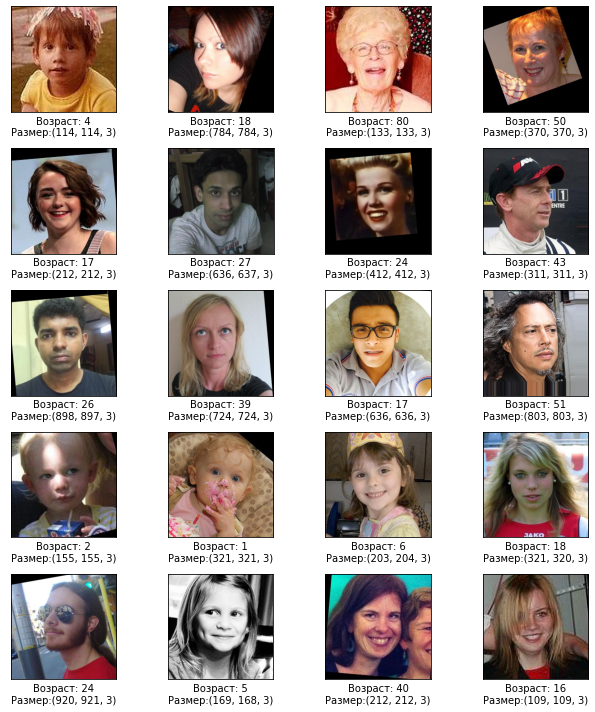

In [21]:
# выводим 20 изображений
fig = plt.figure(figsize=(10,10))
for i in range(20):
    fig.add_subplot(5, 4, i+1)
    """
    для удобства указываем спец. формат:
    0 - все недостающие значения из последовательности заполняются 0
    6 - общее количество символов в последовательности
    d - тип данных десятичное число
    """
    photo = np.array(Image.open(f'/datasets/faces/final_files/{i:06d}.jpg'))
    plt.imshow(photo)
    
    #при помощи лог. индексации получаем возраст, 
    #чтобы отобразилось только значение без тех. информации указываем values[0]
    age = df.loc[df["file_name"] == f'{i:06d}.jpg', "real_age"].values[0]
    
    #отображаем возраст и размер под фотографиями
    plt.xlabel(f'Возраст: {age}\nРазмер:{photo.shape}')
   
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Из полученных фотографий видно следующее:**
 - часть объектов повернута и обрезана, видимо при создании этого датасета с фотографиями была попытка выделения и поворота лиц на первоначальных изображениях для их вертикального выравнивания. Но также присутствуют изображения, на которых лица остались прежними и повернутыми относительно вертикальной оси. При обучении нужно будет применить аугментацию, а именно `rotation_range`
 - часть фотографий сдвинута или уменьшена, попробуем применить сдвиги при обучении
 - размеры фотографий разные
 - все фотографии имеют 3 канала
 - возраст к фотографиям размечен корректно

**На этапе исследовательского анализа были получены следующие результаты:**

**В загруженном датасете:**
 - 7591 строка, что соответствует кол-ву фотографий в папке `/datasets/faces/final_files`. Наименования первых 10 фотографий в датасете также соответствуют названиям первых 10 файлов с фотографиями
 - нет явных пропущенных значений
 - наименования столбцов приведены к `змеиному` регистру
 - типы данных в столбцах корректны 

**Из полученных графиков распределения возраста видно:**
 - чаще всех встречаются люди в возрасте от 26 до 32 лет
 - люди в возрасте от 20 до 41 года составляют 50% людей, входящих в диапазон с самыми распространенными значениями вокруг медианы (межквартильный размах)
 - медианное значение возраста составляет 29 лет
 - не мало добавлено фотографий младенцев до 3 лет
 - пенсионеров свыше 70 лет намного меньше, чем остальных возрастных групп

**Из загруженных фотографий видно следующее:**
 - часть объектов повернута и обрезана, видимо при создании этого датасета с фотографиями была попытка выделения и поворота лиц на первоначальных изображениях для их вертикального выравнивания. Но также присутствуют изображения, на которых лица остались прежними и повернутыми относительно вертикальной оси. При обучении нужно будет применить аугментацию, а именно `rotation_range`
 - часть фотографий сдвинута или уменьшена, попробуем применить сдвиги при обучении
 - размеры фотографий разные
 - все фотографии имеют 3 канала
 - возраст к фотографиям размечен корректно

## Обучение модели

### Динамическая загрузка данных и проверка

Сначала воспользуемся динамической загрузкой данных при помощи загрузчика ImageDataGenerator(). Валидационную выборку сделаем 25%, и сразу проведем нормализацию. Пока протестируем код на работоспособность, поэтому аугментацию, переменную `path` и работу через объявление функций добавим на шаге обучения основной модели. Так как мы решаем задачу регрессии, то укажем `class_mode='raw'`, а так как у первых 20 фотографий 3 канала, что укажем  `color_mode='rgb'`. Даже если в фотографиях будет не три канала, загрузчик автоматически преобразует фотографию в 3-ех канальную. Создавать отдельную переменную `random_state` не будем, так как это может привести к ошибке при дальнейшем обучении основной модели в тренажере в среде Яндекса. При загрузке укажем полный путь к папке с фотографиями и также укажем датасет, в котором есть два столбца - столбец с наименованиями фотографий и столбец с целевым размеченным признаком.

In [9]:
#создаем объект для динамической загрузки данных для тренировочной выборки
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

#создаем объект для динамической загрузки данных для тестовой выборки
test_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

#загружаем данные по указанному пути и с указанным размеченным датасетом
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv('/datasets/faces/labels.csv'),
    directory='/datasets/faces/final_files',
    x_col='file_name', #столбец с наименованиями фотографий
    y_col='real_age', #столбец с разметкой
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',  # для регрессии
    color_mode='rgb', #даже если не три канала, все преобразуется в 3 канала
    subset='training',
    seed=42)

#загружаем данные по указанному пути и с указанным размеченным датасетом
test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe=pd.read_csv('/datasets/faces/labels.csv'),
    directory='/datasets/faces/final_files',
    x_col='file_name', #столбец с наименованиями фотографий
    y_col='real_age', #столбец с разметкой
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',  # для регрессии
    color_mode='rgb', #даже если не три канала, все преобразуется в 3 канала
    subset='validation',
    seed=42)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


Загрузчики работают корректно. Получим пары из первого батча с фотографией и признаком и проверим размер фотографии

In [10]:
#получаем пары фотография-метка
features, target = next(train_datagen_flow)

#размерность фотографий
features.shape

(16, 150, 150, 3)

Размер фотографий и кол-во каналов получилось указанное нами. Приступим к построению и обучению нейронной сети. Сначала проверим работоспособность кода и построим простую сверточную сеть с одним сверточным слоем с 6 фильтрами с ядром 3х3, одним `AveragePooling2D()` с фильтром 2х2, связующим слоем `Flatten()` и полносвязным слоем `Dense()`. Так как мы решаем задачу регрессии и нам нужно получить итоговые значения возраста, то на последнем полносвязном слое укажем 1 нейрон, а в качестве активации укажем `relu`, так как этот активатор показывал самые лучшие результаты во всех задачах теории. В качестве функции потерь укажем `mse`, а для итоговой метрики укажем `mae`. Если результат не устроит после обучения основной нейронной сети, то поменяем функию потерь и метрику местами. Чтобы обучение не длилось слишком долго, то проверим только на первом шаге, укажем `steps_per_epoch=1`, `validation_steps=1`.

In [11]:
model = Sequential()
model.add(Conv2D(filters=6,
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(150, 150, 3)))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=1, activation='relu'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.fit(train_datagen_flow,
          validation_data=test_datagen_flow,
          # Чтобы обучение не было слишком долгим, указываем
          # количество шагов равным 1
          steps_per_epoch=1,
          validation_steps=1,
          verbose=2, epochs=1)

2025-04-23 17:58:37.424951: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 - 2s - loss: 1438.1334 - mae: 30.3717 - val_loss: 863.3258 - val_mae: 25.3138 - 2s/epoch - 2s/step


**Данные были обработаны при помощи динамического загрузчика ImageDataGenerator(). Корректность кода была проверена на 1 шаге обучения простой сверточной сети с 3 слоями (сверточным, AveragePooling2D() и полносвязным)**

### Построение и обучение сети на основе ResNet50

Теперь возьмем за основу более совершенную сеть на основе ResNet50, оставим в ней основной костяк и добавим два слоя: GlobalAveragePooling2D() и полносвязный Dense() с 1 нейроном и активацией `relu`, так как этот активатор показывал самые лучшие результаты во всех задачах теории.  Не будем замораживать обучение основных слоев сети через `backbone.trainable = False`, так как на нашем небольшом датасете на полносвязном слое коэффициенты просто не успеют должным образом подобраться. Также поменяем полный путь к папке с файлами и датасетом на переменную `path` и обернем все в функции. Для начала попробуем обучить сеть без аугментации на 7 эпохах, размер изображений зададим сначала 150х150, а размер батча 16. В качестве оптимизатора выберем Adam с шагом `lr=0.0001`. Так как первоначальные веса загружены на сервер Яндекса, то вместо weights=`imagenet` укажем weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5' для более быстрой загрузки. В качестве функции потерь зададим `mse`, а в качестве основной метрики укажем `mae`.

```python
import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255
)

    train_data = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(f'{path}/labels.csv'),
    directory= f'{path}/final_files',
    x_col='file_name', #столбец с наименованиями фотографий
    y_col='real_age', #столбец с разметкой
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',  # для регрессии
    color_mode='rgb', #даже если не три канала, все преобразуется в 3 канала
    subset='training',
    seed=42)
    
    return train_data

def load_test(path):
    validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255
    )
    
    test_data = validation_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(f'{path}/labels.csv'),
    directory= f'{path}/final_files',
    x_col='file_name', #столбец с наименованиями фотографий
    y_col='real_age', #столбец с разметкой
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',  # для регрессии
    color_mode='rgb', #даже если не три канала, все преобразуется в 3 канала
    subset='validation',
    seed=42)
    
    return test_data

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)  
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=7, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 
```

**Обучение первой базовой сети без аугментации с batch_size=16, lr=0.0001 и target_size=(150, 150) показало следующие результаты на 7 эпохах:**

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/7
356/356 - 60s - loss: 228.9132 - mae: 10.9998 - val_loss: 828.5953 - val_mae: 23.7850
Epoch 2/7
356/356 - 48s - loss: 73.1441 - mae: 6.5527 - val_loss: 193.1445 - val_mae: 11.0587
Epoch 3/7
356/356 - 45s - loss: 37.0805 - mae: 4.6944 - val_loss: 81.5602 - val_mae: 6.9126
Epoch 4/7
356/356 - 43s - loss: 20.9701 - mae: 3.5064 - val_loss: 76.1958 - val_mae: 6.5632
Epoch 5/7
356/356 - 44s - loss: 15.2224 - mae: 2.9791 - val_loss: 75.8298 - val_mae: 6.6897
Epoch 6/7
356/356 - 49s - loss: 12.1788 - mae: 2.6577 - val_loss: 76.9417 - val_mae: 6.7568
Epoch 7/7
356/356 - 48s - loss: 10.6055 - mae: 2.4603 - val_loss: 72.7873 - val_mae: 6.4817
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 12s - loss: 72.7873 - mae: 6.4817
```

**Итоговая метрика mae на тестовой выборке получилась 6.4817.**

### Изменение target_size, batch_size и lr

 Попробуем последовательно изменять параметры для улучшения метрики. Сначала изменим размер изображения в параметрах загрузчика со 150х150 до 224х224, тем самым оставив больше деталей на изображении для более точного определения возраста, а если изображение было меньшего размера, то загрузчик его увеличит до указанного.

**Сеть с увеличенным размером фотографий target_size=(224, 224), batch_size=16, lr=0.0001 показала следующие результаты на 7 эпохах:**

```
Train for 356 steps, validate for 119 steps
Epoch 1/7
356/356 - 84s - loss: 225.6911 - mae: 10.9131 - val_loss: 686.5226 - val_mae: 21.1756
Epoch 2/7
356/356 - 65s - loss: 71.9788 - mae: 6.4593 - val_loss: 104.0753 - val_mae: 7.9145
Epoch 3/7
356/356 - 65s - loss: 36.8015 - mae: 4.6893 - val_loss: 78.1318 - val_mae: 6.7842
Epoch 4/7
356/356 - 65s - loss: 22.8262 - mae: 3.7011 - val_loss: 124.6201 - val_mae: 9.0598
Epoch 5/7
356/356 - 65s - loss: 16.5549 - mae: 3.1491 - val_loss: 76.9254 - val_mae: 6.6708
Epoch 6/7
356/356 - 65s - loss: 14.1712 - mae: 2.8746 - val_loss: 72.1091 - val_mae: 6.5207
Epoch 7/7
356/356 - 66s - loss: 12.5219 - mae: 2.6532 - val_loss: 70.9110 - val_mae: 6.4064
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 13s - loss: 70.9110 - mae: 6.4064
```

Метрика на последних двух эпохах немного улучшилась, итоговая составила 6.4064. Теперь увеличим размер батча до 32, хоть  lr в этом случае тоже нужно пропорционально увеличить, но в качестве эксперимента пока оставим шаг learning_rate прежним.

**Результаты с target_size=(224,224), batch_size=32, lr=0.0001:**

```
Train for 178 steps, validate for 60 steps
Epoch 1/7
178/178 - 60s - loss: 242.5946 - mae: 11.1585 - val_loss: 1127.8777 - val_mae: 28.9733
Epoch 2/7
178/178 - 48s - loss: 62.2505 - mae: 5.9720 - val_loss: 755.2035 - val_mae: 22.0184
Epoch 3/7
178/178 - 46s - loss: 30.3908 - mae: 4.2624 - val_loss: 196.7383 - val_mae: 10.7563
Epoch 4/7
178/178 - 46s - loss: 20.4236 - mae: 3.5045 - val_loss: 111.3118 - val_mae: 8.0297
Epoch 5/7
178/178 - 47s - loss: 15.6030 - mae: 3.0537 - val_loss: 90.8717 - val_mae: 7.1613
Epoch 6/7
178/178 - 46s - loss: 12.2539 - mae: 2.7115 - val_loss: 79.6355 - val_mae: 6.9620
Epoch 7/7
178/178 - 46s - loss: 10.5230 - mae: 2.4813 - val_loss: 71.9963 - val_mae: 6.3401
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 71.9963 - mae: 6.3401
```

По эпохам метрика немного стала хуже. Теперь, при увеличении batch_size в 2 раза пропорционально увеличим lr сразу в 2 раза  до 0.0002

**Результаты с target_size=(224,224), batch_size=32, lr=0.0002:**

```
Train for 178 steps, validate for 60 steps
Epoch 1/7
178/178 - 62s - loss: 196.4067 - mae: 10.1323 - val_loss: 677.5617 - val_mae: 20.9284
Epoch 2/7
178/178 - 48s - loss: 67.8731 - mae: 6.2692 - val_loss: 454.3294 - val_mae: 16.0168
Epoch 3/7
178/178 - 49s - loss: 38.4152 - mae: 4.7009 - val_loss: 238.3268 - val_mae: 11.7719
Epoch 4/7
178/178 - 49s - loss: 25.0380 - mae: 3.8740 - val_loss: 120.0528 - val_mae: 8.2775
Epoch 5/7
178/178 - 49s - loss: 17.4335 - mae: 3.2094 - val_loss: 80.7391 - val_mae: 6.8065
Epoch 6/7
178/178 - 49s - loss: 12.7167 - mae: 2.7379 - val_loss: 72.7968 - val_mae: 6.5705
Epoch 7/7
178/178 - 47s - loss: 10.8274 - mae: 2.5247 - val_loss: 67.2765 - val_mae: 6.1292
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 67.2765 - mae: 6.1292
```

На последней эпохе метрика увеличилась по сравнению с предыдущими вариантами. Попробуем в качестве эксперимента еще увеличить шаг lr до 0.0005

**Результаты с target_size=(224,224), batch_size=32, lr=0.0005:**

```
Train for 178 steps, validate for 60 steps
Epoch 1/7
178/178 - 56s - loss: 204.9915 - mae: 10.6440 - val_loss: 1114.2052 - val_mae: 28.7416
Epoch 2/7
178/178 - 45s - loss: 106.1510 - mae: 7.8077 - val_loss: 299.0215 - val_mae: 12.8578
Epoch 3/7
178/178 - 45s - loss: 64.2069 - mae: 6.1732 - val_loss: 339.7095 - val_mae: 13.5944
Epoch 4/7
178/178 - 45s - loss: 42.8016 - mae: 5.0298 - val_loss: 254.5059 - val_mae: 11.9722
Epoch 5/7
178/178 - 45s - loss: 30.4807 - mae: 4.2634 - val_loss: 98.4413 - val_mae: 7.4718
Epoch 6/7
178/178 - 45s - loss: 21.5357 - mae: 3.6057 - val_loss: 94.1185 - val_mae: 7.2436
Epoch 7/7
178/178 - 45s - loss: 17.8598 - mae: 3.2674 - val_loss: 106.4168 - val_mae: 7.5946
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 106.4168 - mae: 7.5946
```

*Метрика ухудшилась на эпохах с таким большим шагом обучения*

**Обучение сети на основе ResNet50 на 7 эпохах и последовательное изменение параметров загрузчика данных и оптимизатора позволило получить следующие результаты:**
- при использовании target_size=(150, 150), batch_size=16, lr=0.0001 была получена итоговая метрика mae=6.4817
- при увеличении target_size=(224, 224), batch_size=16, lr=0.0001 итоговая метрика mae немного улучшилась до 6.4064
-  при увеличении batch_size до 32 и с набором параметров target_size=(224,224), batch_size=32, lr=0.0001 итоговая метрика mae улучшилась до 6.3401**
- ***при увеличении шага обучения до 0.0002 и набором параметров target_size=(224,224), batch_size=32, lr=0.0002 итоговая метрика mae улучшилась до 6.1292***
- еще большее увеличение шага lr=0.0005 ухудшило итоговую метрику до 7.5946.

***В качестве параметров для дальнейшей работы оставим следующий набор параметров:***
 - target_size=(224,224),
 - batch_size=32,
 - lr=0.0002.

### Аугментация

В качестве эксперимента последовательно будем добавлять разные параметры аугментации. Сначала добавим горизонтальный flip, а количество эпох сразу изменим на 10 для всех следующих попыток.

**Результаты с `horizontal_flip=True`:**

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 61s - loss: 197.2082 - mae: 10.2309 - val_loss: 674.0235 - val_mae: 20.9001
Epoch 2/10
178/178 - 47s - loss: 83.4460 - mae: 6.8959 - val_loss: 295.7505 - val_mae: 12.8438
Epoch 3/10
178/178 - 48s - loss: 60.4439 - mae: 5.8703 - val_loss: 298.8595 - val_mae: 12.6844
Epoch 4/10
178/178 - 47s - loss: 41.8554 - mae: 4.9198 - val_loss: 119.3721 - val_mae: 8.3724
Epoch 5/10
178/178 - 47s - loss: 32.1494 - mae: 4.3551 - val_loss: 97.3357 - val_mae: 7.4434
Epoch 6/10
178/178 - 48s - loss: 28.4622 - mae: 4.0636 - val_loss: 110.9381 - val_mae: 8.0536
Epoch 7/10
178/178 - 47s - loss: 23.3221 - mae: 3.6868 - val_loss: 72.4215 - val_mae: 6.3369
Epoch 8/10
178/178 - 47s - loss: 18.7377 - mae: 3.3111 - val_loss: 67.3137 - val_mae: 6.1935
Epoch 9/10
178/178 - 47s - loss: 15.3926 - mae: 2.9867 - val_loss: 66.1447 - val_mae: 6.1080
Epoch 10/10
178/178 - 47s - loss: 13.2161 - mae: 2.7666 - val_loss: 72.9331 - val_mae: 6.4138
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 72.9331 - mae: 6.4138
```

На 7, 8 и 9 эпохе был получен хороший результат метрики, на 9 эпохе была даже показана лучшая метрика из предыдущих. Теперь горизонтальный флип поменяем на вертикальный.

**Результаты с `vertical_flip=True`:**

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 56s - loss: 223.4625 - mae: 11.0302 - val_loss: 440.9370 - val_mae: 15.8205
Epoch 2/10
178/178 - 44s - loss: 102.5320 - mae: 7.6972 - val_loss: 313.6458 - val_mae: 13.0861
Epoch 3/10
178/178 - 44s - loss: 71.9213 - mae: 6.4132 - val_loss: 265.1329 - val_mae: 12.1985
Epoch 4/10
178/178 - 44s - loss: 56.0424 - mae: 5.7055 - val_loss: 196.2935 - val_mae: 10.2676
Epoch 5/10
178/178 - 44s - loss: 43.3795 - mae: 5.0567 - val_loss: 112.6310 - val_mae: 7.9018
Epoch 6/10
178/178 - 44s - loss: 34.8688 - mae: 4.5196 - val_loss: 106.7819 - val_mae: 8.1255
Epoch 7/10
178/178 - 44s - loss: 27.7824 - mae: 4.0187 - val_loss: 103.7771 - val_mae: 8.0213
Epoch 8/10
178/178 - 44s - loss: 23.7330 - mae: 3.7590 - val_loss: 75.5054 - val_mae: 6.6294
Epoch 9/10
178/178 - 45s - loss: 20.6115 - mae: 3.4677 - val_loss: 74.0226 - val_mae: 6.5205
Epoch 10/10
178/178 - 45s - loss: 18.0576 - mae: 3.2435 - val_loss: 79.2841 - val_mae: 6.6774
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 79.2841 - mae: 6.6774
```

Результат с `vertical_flip` оказался хуже, чем при `horizontal_flip`. Теперь попробуем добавить сдвиги

**Результаты с `width_shift_range=0.2` и `height_shift_range=0.2`:**

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 121s - loss: 217.5589 - mae: 10.7147 - val_loss: 766.5911 - val_mae: 22.6620
Epoch 2/10
178/178 - 108s - loss: 95.7421 - mae: 7.3561 - val_loss: 683.3992 - val_mae: 21.0058
Epoch 3/10
178/178 - 108s - loss: 67.7480 - mae: 6.2811 - val_loss: 394.0623 - val_mae: 14.8348
Epoch 4/10
178/178 - 108s - loss: 54.6150 - mae: 5.6615 - val_loss: 158.8994 - val_mae: 9.3041
Epoch 5/10
178/178 - 109s - loss: 43.4342 - mae: 5.0962 - val_loss: 87.2284 - val_mae: 7.1869
Epoch 6/10
178/178 - 111s - loss: 37.0458 - mae: 4.6922 - val_loss: 88.5724 - val_mae: 6.8648
Epoch 7/10
178/178 - 113s - loss: 31.3557 - mae: 4.3143 - val_loss: 74.4477 - val_mae: 6.5837
Epoch 8/10
178/178 - 113s - loss: 26.7061 - mae: 3.9954 - val_loss: 80.9220 - val_mae: 6.8352
Epoch 9/10
178/178 - 113s - loss: 24.5630 - mae: 3.8029 - val_loss: 145.7798 - val_mae: 8.8490
Epoch 10/10
178/178 - 113s - loss: 20.6833 - mae: 3.5353 - val_loss: 72.4074 - val_mae: 6.2908
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 72.4074 - mae: 6.2908
```

Результат лучше, чем при флипах, но все равно уступает варианту без аугментации. Теперь попробуем использовать повороты, так как в нашем наборе были повернутые фотографии, диапазон наклона выберем 20.

**Результаты с `rotation_range=20`:**

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 118s - loss: 218.4174 - mae: 10.6436 - val_loss: 522.9541 - val_mae: 17.7026
Epoch 2/10
178/178 - 108s - loss: 95.2727 - mae: 7.4141 - val_loss: 408.2348 - val_mae: 15.0064
Epoch 3/10
178/178 - 108s - loss: 70.5480 - mae: 6.4067 - val_loss: 377.3800 - val_mae: 14.4008
Epoch 4/10
178/178 - 110s - loss: 55.8832 - mae: 5.6549 - val_loss: 144.9767 - val_mae: 9.0648
Epoch 5/10
178/178 - 110s - loss: 44.1535 - mae: 5.0957 - val_loss: 108.4201 - val_mae: 7.6811
Epoch 6/10
178/178 - 109s - loss: 36.5262 - mae: 4.6229 - val_loss: 71.8443 - val_mae: 6.3436
Epoch 7/10
178/178 - 108s - loss: 28.6875 - mae: 4.1310 - val_loss: 139.5447 - val_mae: 9.1595
Epoch 8/10
178/178 - 108s - loss: 23.6133 - mae: 3.7551 - val_loss: 74.6940 - val_mae: 6.4553
Epoch 9/10
178/178 - 108s - loss: 21.6286 - mae: 3.6108 - val_loss: 69.2078 - val_mae: 6.3357
Epoch 10/10
178/178 - 107s - loss: 17.5024 - mae: 3.1927 - val_loss: 67.9647 - val_mae: 5.9734
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 67.9647 - mae: 5.9734
```

**Благодаря применению `rotation_range=20` была достигнута лучшая итоговая метрика mae=5.9734**. 

Теперь попробуем объединить несколько методик аугментации одновременно (горизонтальный флип, сдвиги и повороты) и посмотреть на итоговую метрику.

**Результаты с `width_shift_range=0.2, height_shift_range=0.2, rotation_range=20, horizontal_flip=True`:**

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 126s - loss: 208.0205 - mae: 10.5794 - val_loss: 847.3155 - val_mae: 24.1124
Epoch 2/10
178/178 - 115s - loss: 107.4408 - mae: 7.8256 - val_loss: 569.3563 - val_mae: 18.7261
Epoch 3/10
178/178 - 113s - loss: 90.3336 - mae: 7.2376 - val_loss: 337.9113 - val_mae: 13.5641
Epoch 4/10
178/178 - 112s - loss: 77.7746 - mae: 6.6826 - val_loss: 130.6767 - val_mae: 8.6783
Epoch 5/10
178/178 - 113s - loss: 69.6727 - mae: 6.3708 - val_loss: 132.7313 - val_mae: 8.9627
Epoch 6/10
178/178 - 115s - loss: 62.8431 - mae: 5.9958 - val_loss: 79.6868 - val_mae: 6.7864
Epoch 7/10
178/178 - 114s - loss: 55.6915 - mae: 5.7011 - val_loss: 139.7856 - val_mae: 8.9544
Epoch 8/10
178/178 - 115s - loss: 52.5487 - mae: 5.5307 - val_loss: 83.5267 - val_mae: 6.9700
Epoch 9/10
178/178 - 115s - loss: 47.6927 - mae: 5.2946 - val_loss: 80.0631 - val_mae: 6.8019
Epoch 10/10
178/178 - 114s - loss: 44.7016 - mae: 5.1326 - val_loss: 81.2910 - val_mae: 6.7086
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 81.2910 - mae: 6.7086
```

Решение объединить все методы аугментации вместе себя не оправдало, метрика стала хуже, теперь попробуем оставить только повороты и горизонтальный флип, так как по отдельности эти методы показали хорошую итоговую метрику.

**Результаты с `rotation_range=20, horizontal_flip=True`:**

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 121s - loss: 212.5914 - mae: 10.5996 - val_loss: 678.5745 - val_mae: 20.9877
Epoch 2/10
178/178 - 115s - loss: 100.1152 - mae: 7.6338 - val_loss: 495.9482 - val_mae: 17.0095
Epoch 3/10
178/178 - 112s - loss: 80.4930 - mae: 6.7995 - val_loss: 390.8060 - val_mae: 14.7195
Epoch 4/10
178/178 - 116s - loss: 67.2631 - mae: 6.2318 - val_loss: 157.3005 - val_mae: 9.5006
Epoch 5/10
178/178 - 117s - loss: 62.3434 - mae: 5.9602 - val_loss: 105.9537 - val_mae: 7.8236
Epoch 6/10
178/178 - 116s - loss: 50.4433 - mae: 5.4218 - val_loss: 84.3937 - val_mae: 6.9565
Epoch 7/10
178/178 - 111s - loss: 44.9071 - mae: 5.1033 - val_loss: 85.5681 - val_mae: 6.7779
Epoch 8/10
178/178 - 113s - loss: 38.7198 - mae: 4.7688 - val_loss: 76.0329 - val_mae: 6.4523
Epoch 9/10
178/178 - 113s - loss: 34.5716 - mae: 4.5349 - val_loss: 122.9409 - val_mae: 8.8098
Epoch 10/10
178/178 - 115s - loss: 28.7970 - mae: 4.1316 - val_loss: 83.9887 - val_mae: 6.9573
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 83.9887 - mae: 6.9573
```

К сожалению и в этом случае комбинирование нескольких методов аугментации не привело к повышению итоговой метрики.

*Применение разных методов аугментации при обучении сети на 10 эпохах  с набором настроек target_size=(224,224), batch_size=32, lr=0.0002 позволило получить следующие результаты:*
 - применение `horizontal_flip=True` улучшило метрику на 8 и 9 эпохе по сравнению с вариантом без аугментации
 - применение `vertical_flip=True` ухудшило метрику, чем в варианте без аугментации.
 - применение `width_shift_range=0.2` и `height_shift_range=0.2` также не улучшило метрику без аугментации
 - ***применение `rotation_range=20` позволило улучшить итоговую метрику mae до 5.9734***
 - комбинированное использование разных методов аугментации не позволило улучшить итоговую метрику.

***Лучшая итоговая метрика mae=5.9734 при 10 эпохах была получена при применении `rotation_range=20`***

### Добавление колбэков, изменение активации и добавление слоев нормализации и регуляризации

Следующим шагом попробуем еще модернизировать обучение нашей сети, выполнив последовательно следующие этапы:
- вместо `rescale=1./255` добавим `preprocessing_function=preprocess_input` в динамический загрузчик для того, чтобы вместо ручной нормализации изображений, добавить точно такие же преобразования, которые применялись к изображениям в процессе обучения сети `ResNet50` при подборе весов.
- изменим активацию в полносвязном выходном слое с `relu` на `None`, в этом случае будет использована по умолчанию линейная активация `linear`. 
- увеличим кол-во эпох до 25 и применим колбэк `LearningRateScheduler()` для того, чтобы первые 15 эпох обучались с шагом `lr=0.0002`, а следующие 10 эпох обучались с шагом `lr=0.00002`. Потом в качестве эксперимента проведем обучение на шагах `lr=0.0001` и `lr=0.00001` соответственно.
- в связи с увеличением кол-ва эпох добавим другой колбэк - `EarlyStopping()`, который отслеживает указанное нами кол-во эпох без улучшения метрики и в случае достижения этого числа откатывает модель, заново ее обучает до той эпохи, на которой была получена лучшая метрика, тем самым восстанавалиает нужные веса. Тем самым мы ускорим обучение и получим лучшую метрику за все эпохи. В качестве кол-ва отслеживаемых эпох без улучшения укажем 7.
- также попробуем добавить два новых слоя в модель - нормализацию `BatchNormalization()`, приводящую к единому масштабу входные данные слоя и снижающую чувствительность к выбросам и регуляризацию `Dropout()`, выключающую случайным образом указанную часть нейронов от общего кол-ва в слое и помогающую избежать переобучения. Также регуляризация `Dropout()` помогает предотвратить слишком сильную зависимость от конкретных признаков. Так как у нас основной костяк от ResNet50, то добавим всего один раз эти слои перед полносвязным слоем.

Для начала попробуем для лучшего сочетания параметров из прошлого раздела изменить активацию на последнем полносвязном слое с `relu` на None, что эквивалентно `linear`, остальные параметры берем из прошлого раздела:
 - target_size=(224,224),
 - batch_size=32,
 - lr=0.0002,
 - rotation_range=20
 
Также для все следующих попыток изменим ручную нормализацию `rescale=1./255` на `preprocessing_function=preprocess_input`

**Результаты с функцией активации `linear`**

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2025-04-24 16:36:21.428967: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-04-24 16:36:21.863625: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 114s - loss: 208.3764 - mae: 10.3802 - val_loss: 589.5813 - val_mae: 19.1744
Epoch 2/10
178/178 - 104s - loss: 95.1053 - mae: 7.4068 - val_loss: 571.5680 - val_mae: 18.7197
Epoch 3/10
178/178 - 99s - loss: 68.1568 - mae: 6.3016 - val_loss: 218.7905 - val_mae: 10.8689
Epoch 4/10
178/178 - 100s - loss: 52.9629 - mae: 5.5582 - val_loss: 112.1900 - val_mae: 7.9505
Epoch 5/10
178/178 - 99s - loss: 44.3055 - mae: 5.1097 - val_loss: 104.4744 - val_mae: 7.6395
Epoch 6/10
178/178 - 101s - loss: 37.4936 - mae: 4.7090 - val_loss: 86.9455 - val_mae: 6.8042
Epoch 7/10
178/178 - 100s - loss: 30.6552 - mae: 4.2716 - val_loss: 77.8835 - val_mae: 6.5580
Epoch 8/10
178/178 - 100s - loss: 25.3584 - mae: 3.8737 - val_loss: 75.7466 - val_mae: 6.6728
Epoch 9/10
178/178 - 100s - loss: 20.5991 - mae: 3.4984 - val_loss: 73.4929 - val_mae: 6.5880
Epoch 10/10
178/178 - 99s - loss: 16.9301 - mae: 3.1817 - val_loss: 80.1965 - val_mae: 6.6033
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 80.1965 - mae: 6.6033
```

Метрика с активацией `linear` получилась намного хуже, чем с активацией `relu`

Теперь попробуем добавить колбэки.Увеличим кол-во эпох до 25 и применим колбэк LearningRateScheduler() для того, чтобы первые 15 эпох обучались с шагом lr=0.0002, а следующие 10 эпох обучались с шагом lr=0.00002. Добавим его отдельной функцией в функцию `def train_model`. Так как теперь за шаг обучения отвечает колбэк, то в функции по создании модели нет необходимости явно указывать шаг для Adam(). Также в связи с увеличением кол-ва эпох добавим другой колбэк - EarlyStopping(). В качестве эпох без улучшения метрики укажем 7. После внесения изменений функция `def train_model` имеет следующий вид:

```python 
def train_model(model, train_data, test_data, batch_size=None, epochs=25, steps_per_epoch=None, validation_steps=None):
    
    early_stopping = EarlyStopping(monitor='val_mae', #отслеживаемая метрика
                                   patience=7, #кол-во эпох без улучшения
                                   restore_best_weights=True, #восстановление лучших весов
                                   verbose=1)
    # Создаем функцию для изменения learning rate
    def lr(epoch):
        if epoch < 15:
            return 0.0002
        else:
            return 0.00002
    
    lr_scheduler = LearningRateScheduler(lr)

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              callbacks=[early_stopping, lr_scheduler],  #добавление колбэков при обучении
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 
```

**Результаты с `preprocess_input, LearningRateScheduler(), activation=relu, EarlyStopping() на 25 эпохах`:**

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 178 steps, validate for 60 steps
Epoch 1/25
178/178 - 118s - loss: 207.8974 - mae: 10.5801 - val_loss: 140.4240 - val_mae: 8.6401
Epoch 2/25
178/178 - 110s - loss: 91.7976 - mae: 7.2094 - val_loss: 84.3622 - val_mae: 6.8977
Epoch 3/25
178/178 - 104s - loss: 66.7423 - mae: 6.2576 - val_loss: 72.8358 - val_mae: 6.5025
Epoch 4/25
178/178 - 109s - loss: 51.6058 - mae: 5.5090 - val_loss: 74.0853 - val_mae: 6.4272
Epoch 5/25
178/178 - 110s - loss: 42.3395 - mae: 4.9863 - val_loss: 127.6332 - val_mae: 8.4799
Epoch 6/25
178/178 - 110s - loss: 34.3587 - mae: 4.5258 - val_loss: 122.2519 - val_mae: 8.9152
Epoch 7/25
178/178 - 110s - loss: 27.3979 - mae: 4.0349 - val_loss: 91.3441 - val_mae: 7.3006
Epoch 8/25
178/178 - 111s - loss: 26.9580 - mae: 4.0045 - val_loss: 66.5664 - val_mae: 6.1982
Epoch 9/25
178/178 - 111s - loss: 23.0605 - mae: 3.7192 - val_loss: 107.2781 - val_mae: 8.2114
Epoch 10/25
178/178 - 109s - loss: 18.6117 - mae: 3.3232 - val_loss: 73.4258 - val_mae: 6.4883
Epoch 11/25
178/178 - 110s - loss: 18.6582 - mae: 3.3044 - val_loss: 67.1191 - val_mae: 6.1551
Epoch 12/25
178/178 - 111s - loss: 15.1332 - mae: 2.9857 - val_loss: 63.6860 - val_mae: 5.8910
Epoch 13/25
178/178 - 110s - loss: 13.6252 - mae: 2.8418 - val_loss: 63.5939 - val_mae: 5.9951
Epoch 14/25
178/178 - 110s - loss: 11.6346 - mae: 2.6305 - val_loss: 65.7555 - val_mae: 6.0842
Epoch 15/25
178/178 - 110s - loss: 11.5241 - mae: 2.6134 - val_loss: 63.4103 - val_mae: 5.9567
Epoch 16/25
178/178 - 109s - loss: 8.3776 - mae: 2.1699 - val_loss: 57.6778 - val_mae: 5.6871
Epoch 17/25
178/178 - 110s - loss: 6.3525 - mae: 1.8976 - val_loss: 56.6717 - val_mae: 5.6039
Epoch 18/25
178/178 - 110s - loss: 5.1317 - mae: 1.7276 - val_loss: 56.7030 - val_mae: 5.6534
Epoch 19/25
178/178 - 111s - loss: 4.5625 - mae: 1.6206 - val_loss: 56.5521 - val_mae: 5.6215
Epoch 20/25
178/178 - 110s - loss: 4.0369 - mae: 1.5231 - val_loss: 56.2830 - val_mae: 5.6298
Epoch 21/25
178/178 - 110s - loss: 3.6345 - mae: 1.4290 - val_loss: 56.6116 - val_mae: 5.6538
Epoch 22/25
178/178 - 110s - loss: 3.2886 - mae: 1.3717 - val_loss: 55.4124 - val_mae: 5.5690
Epoch 23/25
178/178 - 109s - loss: 2.9751 - mae: 1.3087 - val_loss: 56.2230 - val_mae: 5.6026
Epoch 24/25
178/178 - 109s - loss: 2.6474 - mae: 1.2503 - val_loss: 56.7896 - val_mae: 5.6974
Epoch 25/25
178/178 - 110s - loss: 2.6473 - mae: 1.2330 - val_loss: 56.1875 - val_mae: 5.6236
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 56.1875 - mae: 5.6236
```

***Метрика улучшилась по сравнению с лучшим результатом прошлого раздела и составила 5.6236, благодаря увеличению кол-ва эпох и изменению шага обучения на разных эпохах***

Теперь попробуем тот же набор параметров, только с функцией активации `linear`.

**Результаты с `preprocess_input, LearningRateScheduler(), activation=linear, EarlyStopping() на 25 эпохах`:**

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 178 steps, validate for 60 steps

Epoch 1/25
178/178 - 133s - loss: 195.2636 - mae: 10.1919 - val_loss: 143.4236 - val_mae: 9.1353
Epoch 2/25
178/178 - 104s - loss: 90.1044 - mae: 7.2217 - val_loss: 159.9675 - val_mae: 9.2956
Epoch 3/25
178/178 - 104s - loss: 66.1453 - mae: 6.1871 - val_loss: 96.8360 - val_mae: 7.2836
Epoch 4/25
178/178 - 104s - loss: 49.9222 - mae: 5.4193 - val_loss: 80.7301 - val_mae: 6.7027
Epoch 5/25
178/178 - 103s - loss: 41.5132 - mae: 4.9338 - val_loss: 109.7429 - val_mae: 7.8604
Epoch 6/25
178/178 - 103s - loss: 32.7252 - mae: 4.4309 - val_loss: 72.1016 - val_mae: 6.4264
Epoch 7/25
178/178 - 103s - loss: 26.8648 - mae: 4.0001 - val_loss: 71.0713 - val_mae: 6.2538
Epoch 8/25
178/178 - 103s - loss: 23.3130 - mae: 3.7378 - val_loss: 69.4474 - val_mae: 6.2670
Epoch 9/25
178/178 - 104s - loss: 20.6707 - mae: 3.4610 - val_loss: 65.5238 - val_mae: 6.0479
Epoch 10/25
178/178 - 103s - loss: 19.4530 - mae: 3.3795 - val_loss: 69.1022 - val_mae: 6.2180
Epoch 11/25
178/178 - 103s - loss: 15.5456 - mae: 3.0477 - val_loss: 63.7277 - val_mae: 5.9287
Epoch 12/25
178/178 - 103s - loss: 24.7973 - mae: 3.7383 - val_loss: 76.8779 - val_mae: 6.5860
Epoch 13/25
178/178 - 103s - loss: 19.9469 - mae: 3.4056 - val_loss: 82.1405 - val_mae: 6.7746
Epoch 14/25
178/178 - 103s - loss: 16.6978 - mae: 3.1192 - val_loss: 84.8354 - val_mae: 6.6377
Epoch 15/25
178/178 - 103s - loss: 13.7054 - mae: 2.8425 - val_loss: 66.3512 - val_mae: 5.9485
Epoch 16/25
178/178 - 104s - loss: 9.0626 - mae: 2.2808 - val_loss: 60.0121 - val_mae: 5.7385
Epoch 17/25
178/178 - 104s - loss: 6.8620 - mae: 1.9848 - val_loss: 59.1084 - val_mae: 5.6729
Epoch 18/25
178/178 - 104s - loss: 5.9634 - mae: 1.8546 - val_loss: 58.5478 - val_mae: 5.6549
Epoch 19/25
178/178 - 103s - loss: 5.3252 - mae: 1.7624 - val_loss: 58.3426 - val_mae: 5.6777
Epoch 20/25
178/178 - 103s - loss: 4.5727 - mae: 1.6385 - val_loss: 57.7927 - val_mae: 5.6221
Epoch 21/25
178/178 - 106s - loss: 4.0398 - mae: 1.5398 - val_loss: 57.7824 - val_mae: 5.6350
Epoch 22/25
178/178 - 116s - loss: 3.6643 - mae: 1.4628 - val_loss: 57.9463 - val_mae: 5.6292
Epoch 23/25
178/178 - 115s - loss: 3.5175 - mae: 1.4282 - val_loss: 57.4222 - val_mae: 5.5933
Epoch 24/25
178/178 - 112s - loss: 3.1133 - mae: 1.3478 - val_loss: 57.6250 - val_mae: 5.6374
Epoch 25/25
178/178 - 111s - loss: 2.9640 - mae: 1.3026 - val_loss: 57.7331 - val_mae: 5.6518
WARNING:tensorflow:sample_weight modes were coerced from
  ...
     to  
  ['...']
60/60 - 13s - loss: 57.7331 - mae: 5.6518
```

Метрика на эпохах показала похожий результат, что и с активацией `relu`, но на последней эпохе метрика оказалась немного хуже.

Теперь попробуем добавить два новых слоя в модель - нормализацию BatchNormalization() и регуляризацию Dropout(). Для Dropout() укажем 0.5, это кол-во нейронов слоя, которые будут выключены, что должно помочь уменьшить переобучение. Так как у нас основной костяк от ResNet50, слои которого мы не изменяем, то добавим всего один раз эти слои перед полносвязным последним слоем. Функция `def create_model` примет следующий вид:

```python
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)  
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())  # добавляем нормализацию
    model.add(Dropout(0.5))         # добавляем регуляризацию
    model.add(Dense(units=1, activation='relu'))

    
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

    return model
```

**Результаты с `preprocess_input, LearningRateScheduler(), activation=relu, EarlyStopping(), BatchNormalization(), Dropout(0.5) на 25 эпохах`:**

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 178 steps, validate for 60 steps

Epoch 1/25
178/178 - 119s - loss: 478.3845 - mae: 16.9756 - val_loss: 906.1647 - val_mae: 26.4544
Epoch 2/25
178/178 - 108s - loss: 293.9150 - mae: 13.1882 - val_loss: 356.6275 - val_mae: 14.5791
Epoch 3/25
178/178 - 109s - loss: 285.8959 - mae: 12.7804 - val_loss: 170.4979 - val_mae: 9.9914
Epoch 4/25
178/178 - 109s - loss: 270.6847 - mae: 12.4962 - val_loss: 402.2814 - val_mae: 16.1212
Epoch 5/25
178/178 - 110s - loss: 215.7535 - mae: 10.9247 - val_loss: 115.7281 - val_mae: 8.3966
Epoch 6/25
178/178 - 109s - loss: 161.5641 - mae: 9.3898 - val_loss: 148.4380 - val_mae: 9.2467
Epoch 7/25
178/178 - 109s - loss: 141.3269 - mae: 8.8474 - val_loss: 118.0415 - val_mae: 8.2691
Epoch 8/25
178/178 - 109s - loss: 128.3186 - mae: 8.3703 - val_loss: 97.3165 - val_mae: 7.4593
Epoch 9/25
178/178 - 108s - loss: 147.1855 - mae: 8.6377 - val_loss: 823.5982 - val_mae: 23.6588
Epoch 10/25
178/178 - 123s - loss: 225.1022 - mae: 11.2304 - val_loss: 185.7533 - val_mae: 10.3841
Epoch 11/25
178/178 - 108s - loss: 157.3077 - mae: 9.1270 - val_loss: 930.0984 - val_mae: 25.1319
Epoch 12/25
178/178 - 108s - loss: 125.8412 - mae: 8.1915 - val_loss: 174.4443 - val_mae: 9.5576
Epoch 13/25
178/178 - 109s - loss: 107.8080 - mae: 7.6125 - val_loss: 98.5234 - val_mae: 7.8851
Epoch 14/25
178/178 - 109s - loss: 101.5138 - mae: 7.3442 - val_loss: 98.0733 - val_mae: 7.5138
Epoch 15/25
178/178 - 110s - loss: 91.5349 - mae: 6.9576 - val_loss: 85.8751 - val_mae: 7.0738
Epoch 16/25
178/178 - 109s - loss: 75.9986 - mae: 6.2174 - val_loss: 96.0234 - val_mae: 7.1474
Epoch 17/25
178/178 - 109s - loss: 69.7718 - mae: 5.9408 - val_loss: 103.6533 - val_mae: 7.3476
Epoch 18/25
178/178 - 108s - loss: 70.6730 - mae: 5.8908 - val_loss: 108.7080 - val_mae: 7.4447
Epoch 19/25
178/178 - 118s - loss: 67.4596 - mae: 5.7636 - val_loss: 99.5664 - val_mae: 7.1757
Epoch 20/25
178/178 - 114s - loss: 65.5965 - mae: 5.7707 - val_loss: 108.3488 - val_mae: 7.4275
Epoch 21/25
178/178 - 109s - loss: 62.7390 - mae: 5.5194 - val_loss: 100.3377 - val_mae: 7.3183
Epoch 22/25
Restoring model weights from the end of the best epoch.
178/178 - 109s - loss: 59.7411 - mae: 5.5053 - val_loss: 101.5772 - val_mae: 7.2105
Epoch 00022: early stopping
60/60 - 13s - loss: 85.8751 - mae: 7.0738
```

Видно, что сработал колбэк EarlyStopping() и на 22 эпохе остановил обучение, так как 7 эпох подряд метрика не улучшалась, и восстановил прогресс обучения и веса до 22 эпохи. Но итоговая метрика оказалась намного хуже, чем в нашем предыдущем лучшем варианте без BatchNormalization() и Dropout(0.5). 

Попробуем теперь изменить функцию активации на `linear`.

**Результаты с `preprocess_input, LearningRateScheduler(), activation=linear, EarlyStopping(), BatchNormalization(), Dropout(0.5) на 20 эпохах`:**

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 178 steps, validate for 60 steps

Epoch 1/20
178/178 - 119s - loss: 1101.9677 - mae: 30.7217 - val_loss: 1180.8665 - val_mae: 32.3051
Epoch 2/20
178/178 - 110s - loss: 895.1830 - mae: 28.0521 - val_loss: 1222.1303 - val_mae: 32.8134
Epoch 3/20
178/178 - 110s - loss: 637.7886 - mae: 23.4180 - val_loss: 504.3568 - val_mae: 19.8237
Epoch 4/20
178/178 - 110s - loss: 349.2706 - mae: 16.5911 - val_loss: 335.0527 - val_mae: 15.6659
Epoch 5/20
178/178 - 109s - loss: 154.9773 - mae: 10.1845 - val_loss: 128.0255 - val_mae: 8.4688
Epoch 6/20
178/178 - 110s - loss: 82.4837 - mae: 7.1039 - val_loss: 101.2150 - val_mae: 7.7375
Epoch 7/20
178/178 - 108s - loss: 61.6634 - mae: 6.0535 - val_loss: 81.6884 - val_mae: 6.9869
Epoch 8/20
178/178 - 109s - loss: 58.7948 - mae: 5.9468 - val_loss: 93.5605 - val_mae: 7.2787
Epoch 9/20
178/178 - 109s - loss: 55.4479 - mae: 5.7856 - val_loss: 89.6817 - val_mae: 7.2760
Epoch 10/20
178/178 - 109s - loss: 52.0535 - mae: 5.6181 - val_loss: 82.3091 - val_mae: 7.1390
Epoch 11/20
178/178 - 109s - loss: 42.6911 - mae: 5.0204 - val_loss: 64.2359 - val_mae: 6.0939
Epoch 12/20
178/178 - 104s - loss: 37.0058 - mae: 4.7240 - val_loss: 62.9007 - val_mae: 6.0631
Epoch 13/20
178/178 - 103s - loss: 36.5259 - mae: 4.6919 - val_loss: 63.6405 - val_mae: 6.0435
Epoch 14/20
178/178 - 107s - loss: 33.9410 - mae: 4.5247 - val_loss: 62.4665 - val_mae: 5.9699
Epoch 15/20
178/178 - 110s - loss: 33.2767 - mae: 4.4831 - val_loss: 63.1841 - val_mae: 6.0417
Epoch 16/20
178/178 - 110s - loss: 33.6615 - mae: 4.4583 - val_loss: 63.5737 - val_mae: 6.0612
Epoch 17/20
178/178 - 110s - loss: 31.6529 - mae: 4.3265 - val_loss: 62.8476 - val_mae: 6.0950
Epoch 18/20
178/178 - 109s - loss: 30.3415 - mae: 4.3085 - val_loss: 61.4984 - val_mae: 5.9264
Epoch 19/20
178/178 - 111s - loss: 31.2597 - mae: 4.3232 - val_loss: 61.6517 - val_mae: 5.9096
Epoch 20/20
178/178 - 110s - loss: 30.8125 - mae: 4.2903 - val_loss: 61.5272 - val_mae: 5.9038
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 61.5272 - mae: 5.9038
```

Хоть обучение было проведено на 20 эпохах, а не на 25, но у лучшего набора параметров метрика на 17-20 эпохах была выше на 0.3, чем в этом варианте. С таким набором не удалось улучшить лучшую метрику.

Хоть в предыдущем разделе шаг `lr=0.0001` показывал метрику хуже, чем `lr=0.0002`, но в качестве эксперимента с добавленными  `BatchNormalization()` и `Dropout(0.5)` попробуем изменить шаг обучения на `lr=0.0001` на первых 15 эпохах и `lr=0.00001` на последующих 10 эпохах:

**Результаты с `preprocess_input, LearningRateScheduler(), activation=relu, EarlyStopping(), BatchNormalization(), Dropout(0.5), меняющимся lr=0.0001 и lr=0.00001 на 25 эпохах`:**

```
Train for 178 steps, validate for 60 steps

Epoch 1/25
178/178 - 116s - loss: 531.4842 - mae: 17.4538 - val_loss: 574.4418 - val_mae: 18.8093
Epoch 2/25
178/178 - 107s - loss: 287.6331 - mae: 13.0325 - val_loss: 984.9160 - val_mae: 26.8311
Epoch 3/25
178/178 - 117s - loss: 224.0746 - mae: 11.2094 - val_loss: 372.6803 - val_mae: 13.9037
Epoch 4/25
178/178 - 106s - loss: 209.7356 - mae: 10.7304 - val_loss: 181.0110 - val_mae: 10.0160
Epoch 5/25
178/178 - 107s - loss: 190.4970 - mae: 10.3489 - val_loss: 190.3154 - val_mae: 10.3820
Epoch 6/25
178/178 - 106s - loss: 151.8807 - mae: 9.1162 - val_loss: 242.8925 - val_mae: 11.6623
Epoch 7/25
178/178 - 106s - loss: 147.1583 - mae: 8.7211 - val_loss: 179.0031 - val_mae: 10.4047
Epoch 8/25
178/178 - 107s - loss: 125.2982 - mae: 8.1924 - val_loss: 141.9938 - val_mae: 8.5645
Epoch 9/25
178/178 - 106s - loss: 110.1861 - mae: 7.5562 - val_loss: 194.9863 - val_mae: 10.2310
Epoch 10/25
178/178 - 106s - loss: 106.6052 - mae: 7.2750 - val_loss: 415.6255 - val_mae: 17.1160
Epoch 11/25
178/178 - 111s - loss: 119.6358 - mae: 8.0121 - val_loss: 101.7448 - val_mae: 7.7245
Epoch 12/25
178/178 - 107s - loss: 109.0216 - mae: 7.6742 - val_loss: 94.9557 - val_mae: 7.5212
Epoch 13/25
178/178 - 106s - loss: 110.3465 - mae: 7.9223 - val_loss: 231.5153 - val_mae: 11.9821
Epoch 14/25
178/178 - 107s - loss: 86.5223 - mae: 7.0406 - val_loss: 97.3663 - val_mae: 7.4263
Epoch 15/25
178/178 - 107s - loss: 89.2049 - mae: 6.8977 - val_loss: 220.6442 - val_mae: 11.1442
Epoch 16/25
178/178 - 106s - loss: 84.5062 - mae: 6.9616 - val_loss: 106.3972 - val_mae: 7.7128
Epoch 17/25
178/178 - 107s - loss: 70.5556 - mae: 6.3319 - val_loss: 95.2370 - val_mae: 7.2811
Epoch 18/25
178/178 - 107s - loss: 60.6732 - mae: 5.9113 - val_loss: 99.9809 - val_mae: 7.4101
Epoch 19/25
178/178 - 106s - loss: 57.1125 - mae: 5.6939 - val_loss: 91.7980 - val_mae: 7.1052
Epoch 20/25
178/178 - 107s - loss: 54.2617 - mae: 5.6034 - val_loss: 86.9027 - val_mae: 6.9723
Epoch 21/25
178/178 - 107s - loss: 48.0727 - mae: 5.2441 - val_loss: 86.5000 - val_mae: 6.9474
Epoch 22/25
178/178 - 106s - loss: 48.5952 - mae: 5.3241 - val_loss: 83.5152 - val_mae: 6.8544
Epoch 23/25
178/178 - 105s - loss: 45.9508 - mae: 5.1590 - val_loss: 84.1927 - val_mae: 6.9564
Epoch 24/25
178/178 - 107s - loss: 43.5479 - mae: 5.0226 - val_loss: 87.2899 - val_mae: 6.9504
Epoch 25/25
178/178 - 107s - loss: 39.7044 - mae: 4.7956 - val_loss: 89.2424 - val_mae: 7.0050
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 89.2424 - mae: 7.0050
```

Как и ожидалось, метрика получилась не особо высокая, поменяем активацию на `linear`.

**Результаты с `preprocess_input, LearningRateScheduler(), activation=linear, EarlyStopping(), BatchNormalization(), Dropout(0.5), меняющимся lr=0.0001 и lr=0.00001 на 25 эпохах`:**

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 149s - loss: 1133.6720 - mae: 31.2691 - val_loss: 1306.6066 - val_mae: 34.7413
Epoch 2/20
178/178 - 107s - loss: 999.2618 - mae: 30.1566 - val_loss: 1143.1892 - val_mae: 32.5418
Epoch 3/20
178/178 - 107s - loss: 901.5632 - mae: 28.8525 - val_loss: 524.3860 - val_mae: 20.7180
Epoch 4/20
178/178 - 107s - loss: 790.8115 - mae: 27.0369 - val_loss: 700.8070 - val_mae: 24.8879
Epoch 5/20
178/178 - 106s - loss: 653.9967 - mae: 24.5559 - val_loss: 500.5611 - val_mae: 20.6845
Epoch 6/20
178/178 - 111s - loss: 510.2571 - mae: 21.5005 - val_loss: 395.0597 - val_mae: 17.8572
Epoch 7/20
178/178 - 117s - loss: 361.4386 - mae: 17.6860 - val_loss: 331.3704 - val_mae: 15.9344
Epoch 8/20
178/178 - 110s - loss: 239.7787 - mae: 13.9631 - val_loss: 302.1814 - val_mae: 15.0889
Epoch 9/20
178/178 - 106s - loss: 146.2988 - mae: 10.4196 - val_loss: 102.4876 - val_mae: 7.5333
Epoch 10/20
178/178 - 107s - loss: 89.3975 - mae: 7.7442 - val_loss: 85.6378 - val_mae: 6.8107
Epoch 11/20
178/178 - 116s - loss: 64.5219 - mae: 6.4880 - val_loss: 88.6938 - val_mae: 7.0477
Epoch 12/20
178/178 - 106s - loss: 58.2862 - mae: 6.1401 - val_loss: 86.8655 - val_mae: 6.8983
Epoch 13/20
178/178 - 106s - loss: 55.1480 - mae: 5.9783 - val_loss: 81.8999 - val_mae: 6.7230
Epoch 14/20
178/178 - 107s - loss: 50.7758 - mae: 5.7371 - val_loss: 80.4708 - val_mae: 6.6343
Epoch 15/20
178/178 - 106s - loss: 48.8828 - mae: 5.5948 - val_loss: 75.1511 - val_mae: 6.3904
Epoch 16/20
178/178 - 112s - loss: 45.6699 - mae: 5.3550 - val_loss: 76.5988 - val_mae: 6.4621
Epoch 17/20
178/178 - 115s - loss: 41.9529 - mae: 5.1516 - val_loss: 73.7976 - val_mae: 6.3231
Epoch 18/20
178/178 - 106s - loss: 41.6398 - mae: 5.1343 - val_loss: 72.0205 - val_mae: 6.2723
Epoch 19/20
178/178 - 110s - loss: 39.3517 - mae: 4.9538 - val_loss: 68.9451 - val_mae: 6.1387
Epoch 20/20
178/178 - 113s - loss: 38.2141 - mae: 4.8769 - val_loss: 68.3718 - val_mae: 6.1720
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 13s - loss: 68.3718 - mae: 6.1720
        
```

Метрика с активацией `linear`, конечно, улучшилась, но все равно оказалась хуже, чем с шагами `lr=0.0002` для первых 15 эпох и `lr=0.00002` для последующих 10 эпох.

**На этапе добавления колбэков, изменения активации и добавления нормализации и регуляризации были проделаны следующие действия и получены результаты:**

- вместо ручной нормализации `rescale=1./255` добавили `preprocessing_function=preprocess_input` в динамический загрузчик для того, чтобы вместо ручной нормализации изображений, добавить точно такие же преобразования, которые применялись к изображениям в процессе обучения сети `ResNet50` при подборе весов.
- сеть была снова обучена с лучшим набором параметров из предыдущего раздела, но активация полносвязного последнего слоя была изменена на None (в этом случае по умолчанию используется функция активации `linear`). Итоговая метрика mae ухудщилась до **6.6033**.
- для следующих попыток кол-во эпох было увеличено до 25 и  были добавлены колбэки в функцию `def train_model`:
  - `LearningRateScheduler()` для того, чтобы первые 15 эпох обучались с шагом `lr=0.0002`, а следующие 10 эпох обучались с шагом `lr=0.00002`.
  - `EarlyStopping()`, который отслеживает указанное нами кол-во эпох без улучшения метрики и в случае достижения этого числа прекращает обучение и восстанавливает веса до той эпохи, на которой была получена лучшая метрика.  В качестве эпох без улучшения метрики указали 7
  - с увеличенным кол-вом эпох и добавленными колбэками `LearningRateScheduler()` и `EarlyStopping()` получились следующие результаты:
    - с `preprocess_input, LearningRateScheduler(), activation=relu, EarlyStopping()` на 25 эпохах итоговая метрика **mae** составила **5.6236**
    -  с `preprocess_input, LearningRateScheduler(), activation=linear, EarlyStopping()` на 25 эпохах итоговая метрика **mae** составила **5.6518**
- в функцию `def create_model` перед полносвязным последним слоем были добавлены слой  нормализации `BatchNormalization()` и регуляризации `Dropout(0.5)`:
  - с `preprocess_input, LearningRateScheduler(), activation=relu, EarlyStopping(), BatchNormalization(), Dropout(0.5)` на 22 эпохе была получена лучшая метрика **mae=7.0738**
  - с `preprocess_input, LearningRateScheduler(), activation=linear, EarlyStopping(), BatchNormalization(), Dropout(0.5)` на 20 эпохах итоговая метрика **mae** составила **5.9038**
- в качестве эксперимента шаги обучения были изменены на `lr=0.0001` для первых 15 эпох и `lr=0.00001` для последующих 10 эпох:
  - с `preprocess_input, LearningRateScheduler(), activation=relu, EarlyStopping(), BatchNormalization(), Dropout(0.5), меняющимся lr=0.0001 и lr=0.00001` на 25 эпохах итоговая метрика **mae** составила **7.0050**
  - с `preprocess_input, LearningRateScheduler(), activation=linear, EarlyStopping(), BatchNormalization(), Dropout(0.5), меняющимся lr=0.0001 и lr=0.00001` на 25 эпохах итоговая метрика **mae** составила **6.1720**
  
**Полученные результаты показывают следующее:**
- изменение функции активации последнего слоя без колбэков, нормализации и регуляризации с `relu` на `linear` сильно ухудшило итоговую метрику
- добавление колбэков `LearningRateScheduler()` для изменения шага обучения и ранней остановки `EarlyStopping()` и увеличение кол-ва эпох до 25 позволило улучшить итоговую метрику. При этом функция активации последнего слоя не сильно влияла на итоговую метрику, результаты по эпохам с разной активацией (`relu` и `linear`) получились похожие.
- добавление после основного костяка `Resnet50` по одному слою нормализации `BatchNormalization()` и регуляризации `Dropout(0.5)` перед последним полносвязным слоем не позволило улучшить метрику, но было замечено, что при таком наборе функция активации `linear` позволяет добиться лучшей итоговой метрики, чем функция активации последнего слоя `relu`.

**Итоговая лучшая метрика `mae=5.6236` была получена при следующих параметрах:**

- `target_size=(224,224)`,
- `batch_size=32`,
- аугментации `rotation_range=20`
- применения `preprocessing_function=preprocess_input` в динамическом загрузчике `ImageDataGenerator`
- `epochs=25`
- `lr=0.0002` для первых 15 эпох и `lr=0.00002` для последующих 10 эпох, разный шаг задан при помощи добавления колбэка `LearningRateScheduler()`
- 7 шагов для ранней остановки при помощи колбэка `EarlyStopping()` 
- активации `relu` последнего полносвязного слоя

### Итоговый код

**Код для обучения сети, показавшей лучшую метрику mae=5.6236:**

```python
import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

def load_train(path):
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    preprocessing_function=preprocess_input, #вместо rescale=1./255
    rotation_range=20
)

    train_data = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(f'{path}/labels.csv'),
    directory= f'{path}/final_files',
    x_col='file_name', #столбец с наименованиями фотографий
    y_col='real_age', #столбец с разметкой
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',  # для регрессии
    color_mode='rgb', #даже если не три канала, все преобразуется в 3 канала
    subset='training',
    seed=42)
    
    return train_data

def load_test(path):
    validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    preprocessing_function=preprocess_input #вместо rescale=1./255
    )
    
    test_data = validation_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(f'{path}/labels.csv'),
    directory= f'{path}/final_files',
    x_col='file_name', #столбец с наименованиями фотографий
    y_col='real_age', #столбец с разметкой
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',  # для регрессии
    color_mode='rgb', #даже если не три канала, все преобразуется в 3 канала
    subset='validation',
    seed=42)
    
    return test_data

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)  
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))

    model.compile(optimizer=Adam(lr=0.0002), loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=25, steps_per_epoch=None, validation_steps=None):
    
    early_stopping = EarlyStopping(monitor='val_mae', #отслеживаемая метрика
                                   patience=7, #кол-во эпох без улучшения
                                   restore_best_weights=True, #восстановление лучших весов
                                   verbose=1)
    #функция для изменения learning rate
    def lr(epoch):
        if epoch < 15:
            return 0.0002
        else:
            return 0.00002
    
    lr_scheduler = LearningRateScheduler(lr)

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              callbacks=[early_stopping, lr_scheduler],  #добавление колбэков при обучении
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 

```

## Выводы

**На этапе исследовательского анализа были получены следующие результаты:**

**В загруженном датасете:**
 - 7591 строка, что соответствует кол-ву фотографий в папке `/datasets/faces/final_files`. Наименования первых 10 фотографий в датасете также соответствуют названиям первых 10 файлов с фотографиями
 - нет явных пропущенных значений
 - наименования столбцов приведены к `змеиному` регистру
 - типы данных в столбцах корректны 

**Из полученных графиков распределения возраста видно:**
 - чаще всех встречаются люди в возрасте от 26 до 32 лет
 - люди в возрасте от 20 до 41 года составляют 50% людей, входящих в диапазон с самыми распространенными значениями вокруг медианы (межквартильный размах)
 - медианное значение возраста составляет 29 лет
 - не мало добавлено фотографий младенцев до 3 лет
 - пенсионеров свыше 70 лет намного меньше, чем остальных возрастных групп

**Из загруженных фотографий видно следующее:**
 - часть объектов повернута и обрезана, видимо при создании этого датасета с фотографиями производилось выделение и поворот лиц на первоначальных изображениях для их вертикального выравнивания. Но также присутствуют изображения, на которых лица остались прежними и повернутыми относительно вертикальной оси.
 - часть фотографий сдвинута или уменьшена.
 - размеры фотографий разные
 - все фотографии имеют 3 канала
 - возраст к фотографиям размечен корректно

**На этапе обучения моделей были проделаны следующие этапы и получены следующие результаты:**
 - первоначально данные были обработаны при помощи динамического загрузчика ImageDataGenerator().
 - корректность начального кода была проверена на 1 шаге обучения простой сверточной сети с 3 слоями (сверточным, AveragePooling2D() и полносвязным)
 - в дальнейшем код был переписан под более совершенную сеть на основе ResNet50, в которой были оставлены слои основного костяка, а добавлены только два слоя: GlobalAveragePooling2D() и полносвязный Dense() с 1 нейроном и активацией `relu`. Замораживание при обучении основных слоев сети через `backbone.trainable = False` не производилось. Также полный путь к папке с файлами и датасетом был указан в переменной `path`, а все операции загрузки данных, создания и обучения были обернуты в функции.
 - при обучении сети на основе ResNet50 был задан начальный набор параметров, который последовательно изменялся для улучшения метрики:
   - при использовании target_size=(150, 150), batch_size=16, lr=0.0001 была получена итоговая метрика mae=6.4817
   - при увеличении target_size=(224, 224), batch_size=16, lr=0.0001 итоговая метрика mae немного улучшилась до 6.4064
   -  при увеличении batch_size до 32 и с набором параметров target_size=(224,224), batch_size=32, lr=0.0001 итоговая метрика mae улучшилась до 6.3401**
   - ***при увеличении шага обучения до 0.0002 и набором параметров target_size=(224,224), batch_size=32, lr=0.0002 итоговая метрика mae улучшилась до 6.1292***
   - еще большее увеличение шага lr=0.0005 ухудшило итоговую метрику до 7.5946.
 - применение разных методов аугментации в дальнейшем при обучении сети на 10 эпохах  с набором настроек target_size=(224,224), batch_size=32, lr=0.0002 позволило получить следующие результаты:
   - применение `horizontal_flip=True` улучшило метрику на 8 и 9 эпохе по сравнению с вариантом без аугментации
   - применение `vertical_flip=True` ухудшило метрику, чем в варианте без аугментации.
   - применение `width_shift_range=0.2` и `height_shift_range=0.2` также не улучшило метрику без аугментации
   - ***применение `rotation_range=20` позволило улучшить итоговую метрику mae до 5.9734***
   - комбинированное использование разных методов аугментации не позволило улучшить итоговую метрику.

**На этапе добавления колбэков, изменения активации и добавления нормализации и регуляризации были проделаны следующие действия и получены следующие результаты:**

- вместо ручной нормализации `rescale=1./255` добавили `preprocessing_function=preprocess_input` в динамический загрузчик для того, чтобы вместо ручной нормализации изображений, добавить точно такие же преобразования, которые применялись к изображениям в процессе обучения сети `ResNet50` при подборе весов.
- сеть была снова обучена с лучшим набором параметров из предыдущего раздела, но активация полносвязного последнего слоя была изменена на None (в этом случае по умолчанию используется функция активации `linear`). Итоговая метрика mae ухудщилась до **6.6033**.
- для следующих попыток кол-во эпох было увеличено до 25 и  были добавлены колбэки в функцию `def train_model`:
  - `LearningRateScheduler()` для того, чтобы первые 15 эпох обучались с шагом `lr=0.0002`, а следующие 10 эпох обучались с шагом `lr=0.00002`.
  - `EarlyStopping()`, который отслеживает указанное нами кол-во эпох без улучшения метрики и в случае достижения этого числа прекращает обучение и восстанавливает веса до той эпохи, на которой была получена лучшая метрика.  В качестве эпох без улучшения метрики указали 7
  - с увеличенным кол-вом эпох и добавленными колбэками `LearningRateScheduler()` и `EarlyStopping()` получились следующие результаты:
    - с `preprocess_input, LearningRateScheduler(), activation=relu, EarlyStopping()` на 25 эпохах итоговая метрика **mae** составила **5.6236**
    -  с `preprocess_input, LearningRateScheduler(), activation=linear, EarlyStopping()` на 25 эпохах итоговая метрика **mae** составила **5.6518**
- в функцию `def create_model` перед полносвязным последним слоем были добавлены слой  нормализации `BatchNormalization()` и регуляризации `Dropout(0.5)`:
  - с `preprocess_input, LearningRateScheduler(), activation=relu, EarlyStopping(), BatchNormalization(), Dropout(0.5)` на 22 эпохе была получена лучшая метрика **mae=7.0738**
  - с `preprocess_input, LearningRateScheduler(), activation=linear, EarlyStopping(), BatchNormalization(), Dropout(0.5)` на 20 эпохах итоговая метрика **mae** составила **5.9038**
- в качестве эксперимента шаги обучения были изменены на `lr=0.0001` для первых 15 эпох и `lr=0.00001` для последующих 10 эпох:
  - с `preprocess_input, LearningRateScheduler(), activation=relu, EarlyStopping(), BatchNormalization(), Dropout(0.5), меняющимся lr=0.0001 и lr=0.00001` на 25 эпохах итоговая метрика **mae** составила **7.0050**
  - с `preprocess_input, LearningRateScheduler(), activation=linear, EarlyStopping(), BatchNormalization(), Dropout(0.5), меняющимся lr=0.0001 и lr=0.00001` на 25 эпохах итоговая метрика **mae** составила **6.1720**
  
**Полученные результаты показывают следующее:**
- изменение функции активации последнего слоя без колбэков, нормализации и регуляризации с `relu` на `linear` сильно ухудшило итоговую метрику
- добавление колбэков `LearningRateScheduler()` для изменения шага обучения и ранней остановки `EarlyStopping()` и увеличение кол-ва эпох до 25 позволило улучшить итоговую метрику. При этом функция активации последнего слоя не сильно влияла на итоговую метрику, результаты по эпохам с разной активацией (`relu` и `linear`) получились похожие.
- добавление после основного костяка `Resnet50` по одному слою нормализации `BatchNormalization()` и регуляризации `Dropout(0.5)` перед последним полносвязным слоем не позволило улучшить метрику, но было замечено, что при таком наборе функция активации `linear` позволяет добиться лучшей итоговой метрики, чем функция активации последнего слоя `relu`.

**Итоговая лучшая метрика `mae=5.6236` была получена при следующих параметрах:**

- `target_size=(224,224)`,
- `batch_size=32`,
- аугментации `rotation_range=20`
- применения `preprocessing_function=preprocess_input` в динамическом загрузчике `ImageDataGenerator`
- `epochs=25`
- `lr=0.0002` для первых 15 эпох и `lr=0.00002` для последующих 10 эпох, разный шаг задан при помощи добавления колбэка `LearningRateScheduler()`
- 7 шагов для ранней остановки при помощи колбэка `EarlyStopping()` 
- активации `relu` последнего полносвязного слоя